In [19]:
import numpy as np

In [40]:
import torch
import torch.nn as nn

class BatchNorm(nn.Module):
    def __init__(self, num_features, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps

        # learnable params
        self.gamma = nn.Parameter(torch.ones(1, num_features))
        self.beta = nn.Parameter(torch.zeros(1, num_features))

        # running stats
        self.register_buffer("running_mean", torch.zeros(1, num_features))
        self.register_buffer("running_var", torch.ones(1, num_features))

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            var = x.var(dim=0, unbiased=False, keepdim=True)

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.gamma * x_hat + self.beta



=== Without BatchNorm ===
epoch 01 | loss 135.864
epoch 02 | loss 135.862
epoch 03 | loss 135.860
epoch 04 | loss 135.863
epoch 05 | loss 135.857
epoch 06 | loss 135.860
epoch 07 | loss 135.862
epoch 08 | loss 135.862
epoch 09 | loss 135.859
epoch 10 | loss 135.863
epoch 11 | loss 135.863
epoch 12 | loss 135.861
epoch 13 | loss 135.856
epoch 14 | loss 135.864
epoch 15 | loss 135.861
epoch 16 | loss 135.860
epoch 17 | loss 135.858
epoch 18 | loss 135.860
epoch 19 | loss 135.861
epoch 20 | loss 135.860
epoch 21 | loss 135.858
epoch 22 | loss 135.862
epoch 23 | loss 135.864
epoch 24 | loss 135.862
epoch 25 | loss 135.861
epoch 26 | loss 135.861
epoch 27 | loss 135.862
epoch 28 | loss 135.861
epoch 29 | loss 135.860
epoch 30 | loss 135.860

=== With BatchNorm ===
epoch 01 | loss 75.168
epoch 02 | loss 24.695
epoch 03 | loss 13.839
epoch 04 | loss 9.115
epoch 05 | loss 6.205
epoch 06 | loss 5.915
epoch 07 | loss 4.457
epoch 08 | loss 4.137
epoch 09 | loss 3.290
epoch 10 | loss 2.617
epoch 

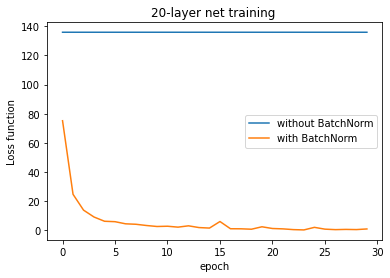

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


torch.manual_seed(0)
N = 50000
D = 100

X = torch.randn(N, D)
y = (X[:, :10].sum(dim=1) > 0).float().unsqueeze(1)


class VeryDeepNoBN(nn.Module):
    def __init__(self, depth=20, width=512):
        super().__init__()
        layers = [nn.Linear(D, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.ReLU()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


class VeryDeepWithBN(nn.Module):
    def __init__(self, depth=20, width=512):
        super().__init__()
        self.fcs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.fcs.append(nn.Linear(D, width))
        self.bns.append(BatchNorm(width))

        for _ in range(depth - 1):
            self.fcs.append(nn.Linear(width, width))
            self.bns.append(BatchNorm(width))

        self.out = nn.Linear(width, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        for fc, bn in zip(self.fcs, self.bns):
            x = self.relu(bn(fc(x)))
        return self.out(x)

def train(model, epochs=30, batch_size=256):
    opt = optim.SGD(model.parameters(), lr=0.05)
    loss_fn = nn.BCEWithLogitsLoss()
    losses = []

    for ep in range(epochs):
        perm = torch.randperm(N)
        epoch_loss = 0.0

        for i in range(0, N, batch_size):
            idx = perm[i:i+batch_size]
            xb, yb = X[idx], y[idx]

            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()

            epoch_loss += loss.item()

        losses.append(epoch_loss)
        print(f"epoch {ep+1:02d} | loss {epoch_loss:.3f}")

    return losses

print("\n=== Without BatchNorm ===")
loss_no_bn = train(VeryDeepNoBN())

print("\n=== With BatchNorm ===")
loss_bn = train(VeryDeepWithBN())

plt.figure()
plt.plot(loss_no_bn, label="without BatchNorm")
plt.plot(loss_bn, label="with BatchNorm")
plt.xlabel("epoch")
plt.ylabel("Loss function")
plt.legend()
plt.title("20-layer net training ")
plt.show()
